<a target="_blank" href="https://colab.research.google.com/github/markusmeister/MIB-Public/blob/master/Figures_Ch_12.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Ch 12 - Advanced Topics in Nonlinear Dynamics

This notebook contains python code for generating figures in Chapter 12 of the book _Mathematics in Biology_.

## Imports and utilities

In [6]:
import numpy as np
from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.markers import MarkerStyle
import matplotlib.gridspec as gridspec
import PIL
import urllib


# set font to be used in figures
import matplotlib.font_manager as font_manager
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'serif'
cmfont = font_manager.FontProperties(fname=matplotlib.get_data_path() + '/fonts/ttf/cmr10.ttf')
matplotlib.rcParams['font.serif']=cmfont.get_name()
matplotlib.rcParams['axes.formatter.use_mathtext'] = True
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['font.size'] = 11

data_url = 'https://raw.githubusercontent.com/markusmeister/MIB-Public/master/data/'

Save = False # set to True if you are saving figures to a local drive
if Save:
    # set path to save the figures
    savedir = Path('../img')
    savedir.mkdir(parents=True, exist_ok=True)

In [7]:
# Utilities for plotting

def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], loc=None, title=None, alpha=1.0,
         xlim=None, ylim=None, xscale='linear', yscale='linear',
         xticks=None, yticks=None, xhide=False, yhide=False, yrot=False,
         xzero=False, yzero=False, yflip=False,
         fmts=['r-','g-','b-','y-','c-','m-'], linewidth=2, markersize=5, fillstyle='full',
         markeredgewidth=1, rasterized=False,
         grid=False, equal=False, figsize=(5,3), axes=None):
    """
    Plot data points.
    X: an array or list of arrays
    Y: an array or list of arrays
    If Y exists then those values are plotted vs the X values
    If Y doesn't exist the X values are plotted
    xlabel, ylabel: axis labels
    legend: list of labels for each Y series
    loc: location of the legend, like 'upper right'
    title: duh
    xlim, ylim: [low,high] list of limits for the 2 axes
    xscale, yscale: 'linear' or 'log'
    xticks, yticks: list of locations for tick marks, or None for auto ticks
    yhide: hide the y axis?
    yrot: rotate the yaxis label to horizontal?
    yzero: zero line for the y-axis?
    fmts: a list of format strings to be applied to successive Y-series
    linewidth, markersize, fillstyle, markeredgewidth: see docs
    grid: draw a grid?
    equal: use equal aspect ratio, i.e. same scale per unit on x and y axis?
    figsize: (h,v) in inches
    rasterized: rasterize the data portion of the graph?
    axes: pre-existing axes where to draw the plot
    Returns: axes for the plot
    """

    if not axes: # start a new figure
        fig = plt.figure(figsize=figsize)
        axes = plt.gca()

    def has_one_axis(X): # Return True if X (ndarray or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    # axes.cla() # clears these axes
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt, linewidth=linewidth, markersize=markersize,
            	fillstyle=fillstyle,markeredgewidth=markeredgewidth,
            	rasterized=rasterized, alpha=alpha)
        else:
            axes.plot(y, fmt, linewidth=linewidth, markersize=markersize,
            	fillstyle=fillstyle,markeredgewidth=markeredgewidth,
            	rasterized=rasterized, alpha=alpha)
    set_axes(axes, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
             xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal)
    if title:
        plt.title(title)
    plt.tight_layout()

    return axes # useful if we started a new figure

def hist(X, bins=50, range=None, density=None, weights=None, histtype='stepfilled', stacked=False,
         align='mid', color=['r','g','b','m'], alpha=0.5, linewidth=1,
         xlabel=None, ylabel=None, legend=[], loc=None, title=None,
         xlim=None, ylim=None, xscale='linear', yscale='linear',
         xticks=None, yticks=None, xhide=False, yhide=False, yrot=False,
         xzero=False, yzero=False, yflip=False,
         grid=False, figsize=(5,3), axes=None, orientation='vertical'):
    """
    Histogram data.
    X: an array or list of arrays to be histogrammed
    bins: the number of bins, or a list of edges
    range: [low,high] the range over which the bins are spread
    density: normalize to unit area?
    weights: array same shape as X; each value in X only contributes that weight.
    histtype: 'bar','barstacked','step','stepfilled'
    stacked: plot multiple series on top of each other?
    align: 'left','mid',right', center the bar on left edge, center, or right edge of bin
    color: list of colors for the data series
    alpha: opacity, useful if histtype='stepfilled'
    xlabel, ylabel: axis labels
    legend: list of labels for each Y series
    loc: location of the legend, like 'upper right'
    title: duh
    xlim, ylim: [low,high] list of limits for the 2 axes
    xscale, yscale: 'linear' or 'log'
    xticks, yticks: list of locations for tick marks, or None for auto ticks
    yhide: hide the y axis?
    yrot: rotate the yaxis label to horizontal?
    yzero: zero line for the y-axis?
    grid: draw a grid?
    figsize: (h,v) in inches
    axes: pre-existing axes where to draw the plot
    Returns: axes, n, bins, patches
    """

    if not axes: # start a new figure
        fig,ax = plt.subplots(figsize=figsize)
    else:
    	ax=axes

    def has_one_axis(X): # Return True if X (ndarray or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list) and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        ndata=1
    else:
        ndata=len(X) # assuming it is an ndarray or a list of lists

    if len(color)<ndata: # if there aren't enough dolors provided
        col=None # use the default color sequence
    else:
        col=color[:ndata]

    if histtype=='step' or histtype=='stepfilled': # in these cases the legend sequence needs to be inverted for some reason
        if isinstance(legend, list):
        	legend = legend[-1::-1]

    n, bins, patches = ax.hist(X, bins=bins, range=range, density=density, weights=weights,
                               histtype=histtype, stacked=stacked, align=align,
                               color=col, alpha=alpha, linewidth=linewidth,
                               label=legend, orientation=orientation)

    set_axes(ax, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
    	xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal=False)

    if title:
        plt.title(title)
    if not axes:
    	plt.tight_layout() # otherwise let the caller take care of layout

    return ax, n, bins, patches # useful if we started a new figure

def set_axes(axes, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
    	xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal):
    """Set the axes for matplotlib."""
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    if xlim:
        axes.set_xlim(xlim)
    else:
        axes.set_xlim(auto=True)
    if ylim:
        axes.set_ylim(ylim)
    else:
        axes.set_ylim(auto=True)
    if grid:
        axes.grid()
    if equal:
        axes.set_aspect(aspect='equal')
    if ylabel:
        if yrot:
            axes.set_ylabel(ylabel, fontsize=12, rotation=0, labelpad=15)
        else:
            axes.set_ylabel(ylabel, fontsize=12)
    if xlabel:
        axes.set_xlabel(xlabel, fontsize=12)
    axes.get_yaxis().set_visible(not yhide)
    axes.get_xaxis().set_visible(not xhide)
    if xzero:
        axes.axvline(color='black', linewidth=0.5)
    if yzero:
        axes.axhline(color='black', linewidth=0.5)
    if yflip:
        axes.invert_yaxis()
    axes.tick_params(axis = 'both', which = 'major', labelsize = 10)
    axes.tick_params(axis = 'both', which = 'minor', labelsize = 9)
    if xticks != None:
        axes.set_xticks(xticks); # no minor ticks
    if yticks != None:
        axes.set_yticks(yticks); # no minor ticks
    if legend:
        axes.legend(legend, loc=loc)
    plt.draw()
    #     To change the font and control the fontsize, can use some of these commands:
    #     axes.set_xlabel(xlabel, fontname='Arial', fontsize = 12)
    #     axes.set_ylabel(ylabel, fontname='Arial', fontsize = 12)
    #     axes.tick_params(axis = 'both', which = 'major', labelsize = 10)
    #     axes.tick_params(axis = 'both', which = 'minor', labelsize = 9)
    #     plt.yticks(fontname = "Arial")
    #     plt.xticks(fontname = "Arial")
    #     if legend:
    #         axes.legend(legend, prop={"size":12, "family":'Arial'})
    #     For options on legend placement see https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

def test_plot():
    x = np.arange(-10,10,.01)
    t = [0.1,0.3,1,3,10]
    y = [np.exp(-x**2/(4*ti))/np.sqrt(4*np.pi*ti) for ti in t]
    plot (x,y,fmts=['r-','g-','b-','y-','c-','m-'],linewidth=1,
        xlabel='Distance',ylabel='Concentration',yzero=True,
        legend=['t=0.1','0.3','1','3','10'],xticks=[-10,-5,-1,0,1,5,10])

## The Turing model of morphogenesis

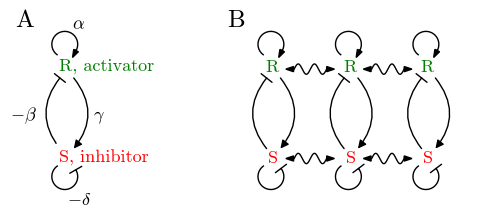

In [8]:
import matplotlib.patches as patches

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,3))

axes.axis('off')
axes.set_xlim([-3,6])
axes.set_ylim([-1.7,2])

fontsize=13

axes.text(-2.05,0.95,r'R, activator',fontsize=fontsize,color='g',zorder=2)
axes.text(-2.05,-0.83,r'S, inhibitor',fontsize=fontsize,color='r',zorder=2)

axes.text(1.95,0.93,r'R',fontsize=fontsize,color='g')
axes.text(2,-0.83,r'S',fontsize=fontsize,color='r')
axes.text(3.45,0.93,r'R',fontsize=fontsize,color='g')
axes.text(3.5,-0.83,r'S',fontsize=fontsize,color='r')
axes.text(4.95,0.93,r'R',fontsize=fontsize,color='g')
axes.text(5,-0.83,r'S',fontsize=fontsize,color='r')

mutation_scale_promotion=12
mutation_scale_inhibition=5

R=0.25
ts=np.linspace(0,6.3,100)
xs=-R*np.sin(ts)
ys=-R*np.cos(ts)


# self activation

axes.plot(xs[10:82]-1.94,ys[10:82]+1.46,color='k',linewidth=1,zorder=0)
axes.arrow(xs[81]-1.94,ys[81]+1.46,xs[82]-xs[81],ys[82]-ys[81],width=0.001,head_width=0.1,overhang=0,color='k',zorder=2)
axes.text(-1.8,1.75,r'$\alpha$',fontsize=fontsize,color='k')

axes.plot(xs[10:82]+2.05,ys[10:82]+1.46,color='k',linewidth=1,zorder=0)
axes.arrow(xs[81]+2.05,ys[81]+1.46,xs[82]-xs[81],ys[82]-ys[81],width=0.001,head_width=0.1,overhang=0,color='k',zorder=2)

axes.plot(xs[10:82]+3.55,ys[10:82]+1.46,color='k',linewidth=1,zorder=0)
axes.arrow(xs[81]+3.55,ys[81]+1.46,xs[82]-xs[81],ys[82]-ys[81],width=0.001,head_width=0.1,overhang=0,color='k',zorder=2)

axes.plot(xs[10:82]+5.05,ys[10:82]+1.46,color='k',linewidth=1,zorder=0)
axes.arrow(xs[81]+5.05,ys[81]+1.46,xs[82]-xs[81],ys[82]-ys[81],width=0.001,head_width=0.1,overhang=0,color='k',zorder=2)

R=0.25
ts=np.linspace(0,6.3,100)
xs=R*np.sin(ts)
ys=R*np.cos(ts)

# self inhibition
axes.plot(xs[17:90]-1.94,ys[17:90]-1.1,color='k',linewidth=1,zorder=0)
axes.add_patch(patches.FancyArrowPatch(posA=(xs[17]-1.94, ys[17]-1.1), posB=(xs[16]-1.94, ys[16]-1.1),
                                          lw=1, arrowstyle=u'|-|, widthA=0, widthB=1',
                                          mutation_scale=5,color='k'))
axes.text(-1.9,-1.65,r'$-\delta$',fontsize=fontsize,color='k')

axes.plot(xs[15:90]+2.05,ys[15:90]-1.1,color='k',linewidth=1,zorder=0)
axes.add_patch(patches.FancyArrowPatch(posA=(xs[15]+2.05, ys[15]-1.1), posB=(xs[14]+2.05, ys[14]-1.1),
                                          lw=1, arrowstyle=u'|-|, widthA=0, widthB=1',
                                          mutation_scale=5,color='k'))

axes.plot(xs[15:90]+3.55,ys[15:90]-1.1,color='k',linewidth=1,zorder=0)
axes.add_patch(patches.FancyArrowPatch(posA=(xs[15]+3.55, ys[15]-1.1), posB=(xs[14]+3.55, ys[14]-1.1),
                                          lw=1, arrowstyle=u'|-|, widthA=0, widthB=1',
                                          mutation_scale=5,color='k'))

axes.plot(xs[15:90]+5.05,ys[15:90]-1.1,color='k',linewidth=1,zorder=0)
axes.add_patch(patches.FancyArrowPatch(posA=(xs[15]+5.05, ys[15]-1.1), posB=(xs[14]+5.05, ys[14]-1.1),
                                          lw=1, arrowstyle=u'|-|, widthA=0, widthB=1',
                                          mutation_scale=5,color='k'))


# interaction in panel A
axes.add_patch(patches.FancyArrowPatch(posA=(-1.8, 0.85), posB=(-1.8, -0.6), connectionstyle="angle3,angleA=-50,angleB=-130",
                                          lw=1, fc='k', arrowstyle=u'-|>',
                                          mutation_scale=mutation_scale_promotion))
axes.text(-1.4,0,r'$\gamma$',fontsize=fontsize,color='k')
axes.add_patch(patches.FancyArrowPatch(posA=(-2, -0.6), posB=(-2, 0.85), connectionstyle="angle3,angleA=-50,angleB=-130",
                                          lw=1, fc='k', arrowstyle=u'|-|',
                                          mutation_scale=mutation_scale_inhibition))
axes.add_patch(patches.Rectangle((-2.15,-0.7), 0.35, 0.15, angle=40, facecolor='w',alpha=1,zorder=1))
axes.text(-3.0,0,r'$-\beta$',fontsize=fontsize,color='k')


# interaction in panel B
axes.add_patch(patches.FancyArrowPatch(posA=(2.2, 0.85), posB=(2.2, -0.6), connectionstyle="angle3,angleA=-50,angleB=-130",
                                          lw=1, fc='k', arrowstyle=u'-|>',
                                          mutation_scale=mutation_scale_promotion))
axes.add_patch(patches.FancyArrowPatch(posA=(2, -0.6), posB=(2, 0.85), connectionstyle="angle3,angleA=-50,angleB=-130",
                                          lw=1, fc='k', arrowstyle=u'|-|, widthA=0, widthB=1',
                                          mutation_scale=mutation_scale_inhibition))
axes.add_patch(patches.FancyArrowPatch(posA=(3.7, 0.85), posB=(3.7, -0.6), connectionstyle="angle3,angleA=-50,angleB=-130",
                                          lw=1, fc='k', arrowstyle=u'-|>',
                                          mutation_scale=mutation_scale_promotion))
axes.add_patch(patches.FancyArrowPatch(posA=(3.5, -0.6), posB=(3.5, 0.85), connectionstyle="angle3,angleA=-50,angleB=-130",
                                          lw=1, fc='k', arrowstyle=u'|-|, widthA=0, widthB=1',
                                          mutation_scale=mutation_scale_inhibition))
axes.add_patch(patches.FancyArrowPatch(posA=(5.2, 0.85), posB=(5.2, -0.6), connectionstyle="angle3,angleA=-50,angleB=-130",
                                          lw=1, fc='k', arrowstyle=u'-|>',
                                          mutation_scale=mutation_scale_promotion))
axes.add_patch(patches.FancyArrowPatch(posA=(5, -0.6), posB=(5, 0.85), connectionstyle="angle3,angleA=-50,angleB=-130",
                                           fc='k', 
                                          arrowstyle=u'|-|, widthA=0, widthB=1',
                                          mutation_scale=mutation_scale_inhibition,
                                          lw=1,))

# panel label
axes.text(-2.9,1.8,r'A',fontsize=18,color='k')
axes.text(1.2,1.8,r'B',fontsize=18,color='k')

x = np.linspace(0,4*np.pi,151)
y = np.sin(x)
Xs=x/20+2.5
Ys=y/10+0.98
axes.plot(Xs,Ys, color="k", lw="1")
axes.arrow(Xs[150],Ys[150],0.001,0,width=0,head_width=0.1,overhang=0,color='k',zorder=2)
axes.arrow(Xs[0]-0.01,Ys[0],-0.001,0,width=0,head_width=0.1,overhang=0,color='k',zorder=2)
Xs=x/20+2.5
Ys=y/10-0.75
axes.plot(Xs,Ys, color="k", lw="1")
axes.arrow(Xs[150],Ys[150],0.001,0,width=0,head_width=0.1,overhang=0,color='k',zorder=2)
axes.arrow(Xs[0]-0.01,Ys[0],-0.001,0,width=0,head_width=0.1,overhang=0,color='k',zorder=2)
Xs=x/20+4
Ys=y/10+0.98
axes.plot(Xs,Ys, color="k", lw="1")
axes.arrow(Xs[150],Ys[150],0.001,0,width=0,head_width=0.1,overhang=0,color='k',zorder=2)
axes.arrow(Xs[0]-0.01,Ys[0],-0.001,0,width=0,head_width=0.1,overhang=0,color='k',zorder=2)
Xs=x/20+4
Ys=y/10-0.75
axes.plot(Xs,Ys, color="k", lw="1")
axes.arrow(Xs[150],Ys[150],0.001,0,width=0,head_width=0.1,overhang=0,color='k',zorder=2)
axes.arrow(Xs[0]-0.01,Ys[0],-0.001,0,width=0,head_width=0.1,overhang=0,color='k',zorder=2)


axes.set_aspect('equal')

if Save:
    fig.savefig(str(savedir / 'ch10_catalysis.pdf'), dpi=600, format='pdf', bbox_inches='tight');
    fig.savefig(str(savedir / 'ch10_catalysis.svg'), dpi=600, format='svg', bbox_inches='tight');

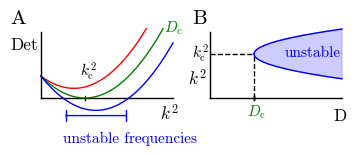

In [9]:
panel_label_fontsize=15
label_fontsize = 11
axis_label_fontsize=12.5

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4,2))

axes[0].plot([0,3],[0,0],color='k',linewidth=1)
axes[0].plot([0,0],[0,1.5],color='k',linewidth=1)

axes[0].axis('off')
axes[0].set_xlim([-0.1,3.1])
axes[0].set_ylim([-0.9,1.6])

axes[0].text(-0.7,1.7,r'A',fontsize=panel_label_fontsize,color='k')
axes[0].text(2.7,-0.5,r'$k^2$',fontsize=axis_label_fontsize,color='k')
axes[0].text(-0.7,1.1,r'Det',fontsize=axis_label_fontsize,color='k')
axes[0].text(0.9,0.5,r'$k_\mathrm{c}^2$',fontsize=label_fontsize,color='k')
axes[0].plot([1,1],[0.05,-0.05],color='k',linewidth=1)
axes[0].text(0.5,-1.0,r'unstable frequencies',fontsize=label_fontsize,color='b')
axes[0].text(2.8,1.5,r'$D_\mathrm{c}$',fontsize=label_fontsize,color='g')

x=np.linspace(0,3,100)
yr=(x**2-1.5*x+1)/2
yg=(x**2-2*x+1)/2
yb=(x**2-2.5*x+1)/2
axes[0].plot(x,yr,lw=1,c='r')
axes[0].plot(x,yg,lw=1,c='g')
axes[0].plot(x,yb,lw=1,c='b')
axes[0].add_patch(patches.FancyArrowPatch(posA=(0.5, -0.4), posB=(2.0, -0.4), connectionstyle="angle3,angleA=0,angleB=-130",
                                          lw=1, fc='b', ec='b',arrowstyle=u'|-|',
                                          mutation_scale=4))

axes[0].set_aspect('equal')



axes[1].plot([0,0],[0,1.5],color='k',linewidth=1)
axes[1].plot([0,3],[0,0],color='k',linewidth=1)

axes[1].axis('off')
axes[1].set_xlim([-0.1,3.1])
axes[1].set_ylim([-0.9,1.6])


axes[1].text(-0.4,1.7,r'B',fontsize=panel_label_fontsize,color='k')
axes[1].text(-0.5,0.3,r'$k^2$',fontsize=axis_label_fontsize,color='k')
axes[1].text(2.8,-0.5,r'D',fontsize=axis_label_fontsize,color='k')
axes[1].text(-0.4,0.9,r'$k_{\mathrm{c}}^2$',fontsize=label_fontsize,color='k')
axes[1].plot([1,1],[0.05,-0.05],color='k',linewidth=1)
axes[1].plot([1,1],[0,1],color='k',linewidth=1,ls='dashed')
axes[1].plot([0,1],[1,1],color='k',linewidth=1,ls='dashed')
axes[1].plot([1,1],[0.05,-0.05],color='k',linewidth=1)
axes[1].text(1.7,0.95,r'unstable',fontsize=label_fontsize,color='b')
axes[1].text(0.85,-0.4,r'$D_\mathrm{c}$',fontsize=label_fontsize,color='g')

x=np.linspace(1,3,200)
yb=0.4*(x-1)**0.5+1
yb2=-0.4*(x-1)**0.5+1
axes[1].plot(x,yb,lw=1,c='b')
axes[1].plot(x,yb2,lw=1,c='b')
N=np.zeros((400,2))
N[0:200,1]=yb
N[200:400,1]=np.flip(yb2)
N[0:200,0]=x
N[200:400,0]=np.flip(x)
axes[1].add_patch(patches.Polygon(N, closed=True,fc='b',ec='b',alpha=0.2))
axes[1].set_aspect('equal')

if Save:
    fig.savefig(str(savedir / 'ch10_detM.pdf'), format='pdf', bbox_inches='tight');
    fig.savefig(str(savedir / 'ch10_detM.svg'), format='svg', bbox_inches='tight');

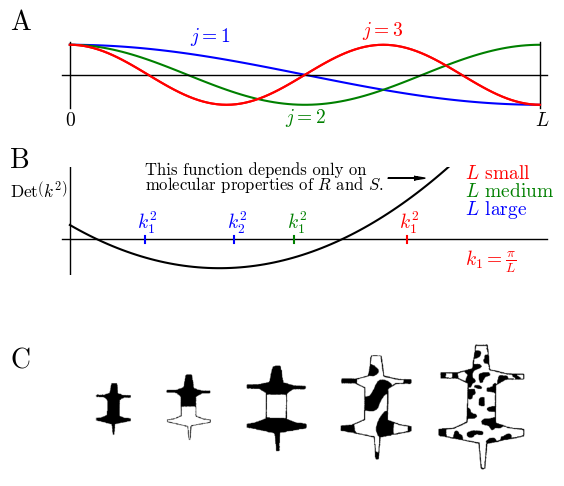

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6,5),gridspec_kw={'height_ratios': [2,3,4]})

axes[0].set_xlim([-0.5,2*np.pi+0.2])
axes[0].set_ylim([-1.2,1.2])
axes[0].axis('off')
axes[0].text(-0.8,1.5,r'A',fontsize=20,color='k')

x=np.linspace(0,2*np.pi,100)
y=np.cos(x/2)
y1=np.cos(2*x/2)
y2=np.cos(3*x/2)

axes[0].plot(x,y,'b')
axes[0].plot(x,y1,'g')
axes[0].plot(x,y2,'r')

axes[0].plot([-0.1,2*np.pi+0.1],[0,0],'k',linewidth=1)
axes[0].plot([0,0],[-1.1,1.1],'k',linewidth=1)
axes[0].plot([2*np.pi,2*np.pi],[-1.1,1.1],'k',linewidth=1)
axes[0].plot(x,y2,'r')
axes[0].text(-0.07,-1.7,r'$0$',fontsize=14,color='k')
axes[0].text(2*np.pi-0.07,-1.7,r'$L$',fontsize=14,color='k')
axes[0].text(1.6,1.1,r'$j=1$',fontsize=14,color='b')
axes[0].text(2.88,-1.6,r'$j=2$',fontsize=14,color='g')
axes[0].text(3.9,1.3,r'$j=3$',fontsize=14,color='r')


axes[1].set_xlim([-0.5,2*np.pi+0.2])
axes[1].set_ylim([-1,2])
axes[1].axis('off')
axes[1].text(-0.8,2,r'B',fontsize=20,color='k')

x=np.linspace(0,2*np.pi,100)
y=0.3*(x-2)**2-0.8

axes[1].plot(x,y,'k')

axes[1].plot([-0.1,2*np.pi+0.1],[0,0],'k',linewidth=1)
axes[1].plot([0,0],[-1,2],'k',linewidth=1)

axes[1].text(-0.8,1.2,r'$\mathrm{Det}\left(k^2\right)$',fontsize=12.5,color='k')

axes[1].plot([1,1],[0.1,-0.1],'b',linewidth=1.5)
axes[1].text(0.9,0.3,r'$k_1^2$',fontsize=14,color='b')

axes[1].plot([2.2,2.2],[0.1,-0.1],'b',linewidth=1.5)
axes[1].text(2.1,0.3,r'$k_2^2$',fontsize=14,color='b')

axes[1].plot([3,3],[0.1,-0.1],'g',linewidth=1.5)
axes[1].text(2.9,0.3,r'$k_1^2$',fontsize=14,color='g')

axes[1].plot([4.5,4.5],[0.1,-0.1],'r',linewidth=1.5)
axes[1].text(4.4,0.3,r'$k_1^2$',fontsize=14,color='r')
axes[1].text(2*np.pi-1,-0.7,r'$k_1=\frac{\pi}{L}$',fontsize=14,color='r')

axes[1].text(2*np.pi-1,1.7,r'$L$ small',fontsize=14,color='r')
axes[1].text(2*np.pi-1,1.2,r'$L$ medium',fontsize=14,color='g')
axes[1].text(2*np.pi-1,0.7,r'$L$ large',fontsize=14,color='b')

axes[1].text(1.0,1.8,r'This function depends only on',fontsize=12,color='k')
axes[1].text(1.0,1.4,r'molecular properties of $R$ and $S$.',fontsize=12,color='k')

axes[1].arrow(4.25,1.7,0.5,0,width=0.001,length_includes_head=True,head_width=0.1,
                overhang=0.5,color='k')

import matplotlib.image as mpimg

ax2 = axes[2].inset_axes([-0.8, -1, 8, 4], transform = axes[2].transData)
im2 = np.array(PIL.Image.open(urllib.request.urlopen(data_url + 'turing_patterns.tif')))
ax2.imshow(im2,cmap='gray')
ax2.axis('off')
axes[2].axis('off')
axes[2].set_xlim([-0.5,2*np.pi+0.2])
axes[2].set_ylim([-1,3])
axes[2].text(-0.8,2,r'C',fontsize=20,color='k')

# axes[2].set_aspect('equal')
fig.tight_layout()
plt.show()

if Save:
    fig.savefig(str(savedir / 'turing-advanced.pdf'), bbox_inches='tight');
    fig.savefig(str(savedir / 'turing-advanced.svg'), bbox_inches='tight');